# Notebook 2: Linear regression and random forests with scikit-learn

Now that we have prepared our data we can start building machine learning models.

We will start with the simplest model: Linear regression

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
DATADIR = './dataset1/'

In [3]:
# Copy from previous notebook
def create_sub(preds, fn=None):
    df =  pd.DataFrame({'Id': range(len(preds)), 'Expected': preds})
    if fn is not None: df.to_csv(DATADIR + fn, index=False)
    return df

In [7]:
# Load the preprocessed data
with open('./tmp/preproc_data.pkl', 'rb') as f:
    X_train, y_train, X_valid, y_valid, X_test = pickle.load(f)
with open('./tmp/dfs.pkl', 'rb') as f:
    df_train, df_test = pickle.load(f)

## Linear regression

$y = \sum_i a_i x_i + b$

### Compute baseline mse

Before we start let's check which score we have to beat.

In [10]:
def mse(y_true, y_pred): return ((y_true - y_pred)**2).mean()

In [11]:
mse(y_valid, df_train.t2m_fc_mean[df_train.time >= '2015-01-01'])

4.135858792431942

### sklearn API

All sklearn models work in exactly the same way.

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
# Create the model object
lr = LinearRegression()

In [14]:
# Fit the model parameters with the training data
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now the parameters $a_i$ and $b$ have been fit to our training data. 

We can not look at the individual parameters.

In [15]:
X_train.columns

Index(['t2m_fc_mean', 'orog', 'station_alt', 'station_lat', 'station_lon',
       'u_pl500_fc_mean', 'v_pl500_fc_mean', 'gh_pl500_fc_mean',
       'u_pl850_fc_mean', 'v_pl850_fc_mean', 'q_pl850_fc_mean', 'cape_fc_mean',
       'sp_fc_mean', 'tcc_fc_mean', 'sshf_fc_mean', 'slhf_fc_mean',
       'u10_fc_mean', 'v10_fc_mean', 'ssr_fc_mean', 'str_fc_mean',
       'd2m_fc_mean', 'sm_fc_mean'],
      dtype='object')

In [16]:
lr.coef_

array([ 5.20734246,  0.53522914, -0.9193415 , -0.14865423, -0.10651631,
        0.01482758, -0.06200976,  0.22355911,  0.08053755, -0.01852129,
        0.14741519, -0.03510716, -0.17207246,  0.17164729,  0.54843072,
       -0.03918102, -0.06724854,  0.13348599,  0.77616008,  0.21138807,
        0.61088598, -0.04088925])

In [17]:
lr.intercept_

7.448795068185583

Wouldn't you expect the coefficient for `t2m_fc_mean` to be around 0 and the bias to be close to one? Why is this not the case?

In [18]:
# Make predictions for validation set
preds = lr.predict(X_valid)

In [19]:
mse(preds, y_valid)

3.2422963614329707

In [20]:
# Submit to Kaggle
df_sub = create_sub(lr.predict(X_test), 'lr.csv'); df_sub.head()

,Id,Expected
0,0,4.195768
1,1,1.528290
2,2,1.475483
3,3,4.318616
4,4,2.337542


### The R$^2$ score

The R$^2$ score is a common skill metric in machine learning: https://en.wikipedia.org/wiki/Coefficient_of_determination

In [21]:
lr.score(X_valid, y_valid)

0.9187372901848856

In [22]:
def print_scores(m, X_train=X_train, X_valid=X_valid):
    print('Train R2 = ', m.score(X_train, y_train), 
          ', Valid R2 = ', m.score(X_valid, y_valid), ', Valid MSE = ', 
          mse(m.predict(X_valid), y_valid))

In [23]:
print_scores(lr)

Train R2 =  0.9319430866570234 , Valid R2 =  0.9187372901848856 , Valid MSE =  3.2422963614329707


We can see that the training and validation score are roughly similar, indicating that the linear regression doesn't seem to be very prone to overfitting.

## Decicion trees

Linear regression improves the score but we can do better. One very common machine learning algorithm are decision trees. They are capable of representing non-linear relationships. In scikit-learn we can use the exact same API as before.

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import display
import IPython, graphviz, re

### Visualize a tree

In [25]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ From fast.ai machine learning course.
    Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

Let's start with a very shallow tree which we can visualize. Again we are using the exact same sklearn API.

In [26]:
dt = DecisionTreeRegressor(max_depth=3)

In [27]:
%time dt.fit(X_train, y_train)

CPU times: user 5.53 s, sys: 0 ns, total: 5.53 s
Wall time: 5.53 s


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

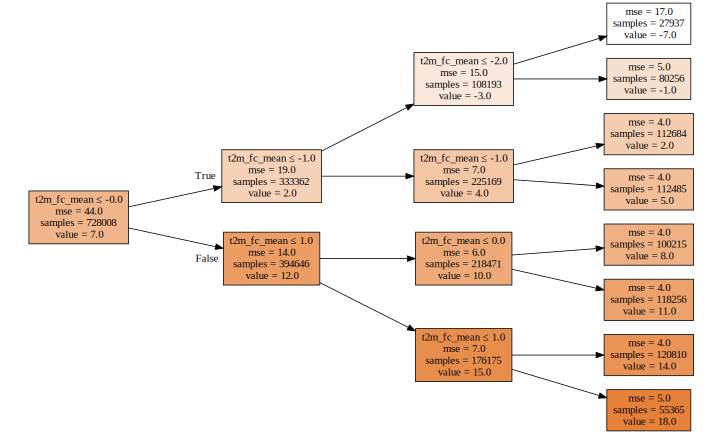

In [28]:
draw_tree(dt, df_train.drop(['t2m_obs', 'time', 'station'], 1))

Here we can see that the splits are entirely based on `t2m_fc_mean` which is not surpising.

### Build a full tree

Now let's actually build a complicated tree.

In [29]:
dt = DecisionTreeRegressor()

In [30]:
%time dt.fit(X_train, y_train)

CPU times: user 34 s, sys: 0 ns, total: 34 s
Wall time: 34 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [31]:
print_scores(dt)

Train R2 =  1.0 , Valid R2 =  0.8427923226726671 , Valid MSE =  6.272420417033087


In [43]:
dt.tree_.node_count

1291953

So we have a perfect score on the training dataset, but a pretty awful score on the validation set. This is an extreme case of overfitting!

But this is to be expected. We built our tree to perfectly fit the training set, so that only one sample remains in the final leafs.

### Reduce the complexity of the tree

To combat this we can set the minimum number of samples in each final leaf to a higher value.

In [44]:
dt = DecisionTreeRegressor(min_samples_leaf=200)

In [45]:
%time dt.fit(X_train, y_train)

CPU times: user 22.1 s, sys: 0 ns, total: 22.1 s
Wall time: 22.1 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=200,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [46]:
print_scores(dt)

Train R2 =  0.939008732905577 , Valid R2 =  0.9112729295089091 , Valid MSE =  3.5401164749291705


The overfitting is less bad now but we still cannot get a better score than with linear regression. We need to do better!

## Random forests

Here is where random forests are coming in. As the name suggests, a random forest is an ensemble of decision trees, where each tree is build with a random subsample of the features and training data. This should help to prevent overfitting.

In [47]:
from sklearn.ensemble import RandomForestRegressor

### Fit a sample model

Now we are fitting several decision trees. This can be done in parallel by several processors. `n_jobs = -1` uses all available processors.

In [48]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)

In [49]:
%time rf.fit(X_train, y_train)

CPU times: user 4min 34s, sys: 144 ms, total: 4min 34s
Wall time: 29.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [50]:
print_scores(rf)

Train R2 =  0.9923784978318793 , Valid R2 =  0.9171492011905503 , Valid MSE =  3.3056594363252723


Again, we see that we are overfitting quite badly. As before, we can tune the hyper-parameters to prevent overfitting

### Hyperparameters


#### min_samples_leaf

The minimum number of sample is each leaf.

In [51]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, min_samples_leaf=100)

In [52]:
%time rf.fit(X_train, y_train)

CPU times: user 3min 11s, sys: 76 ms, total: 3min 11s
Wall time: 20.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [53]:
print_scores(rf)

Train R2 =  0.9468109911673573 , Valid R2 =  0.9192623595469146 , Valid MSE =  3.221346648017444


#### n_estimators

The number of trees. 

In [54]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=10)

In [55]:
%time rf.fit(X_train, y_train)

CPU times: user 20min 52s, sys: 468 ms, total: 20min 53s
Wall time: 1min 8s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [56]:
print_scores(rf)

Train R2 =  0.9758792913984392 , Valid R2 =  0.9236987002474748 , Valid MSE =  3.044341335934703


We are still getting a much better score on the training set. Partly we are still overfitting, but partly this is to be expected from our dataset and the way we chose the validation set. Can you explain why?

Let's submit our new best model to kaggle.

In [57]:
# Submit to Kaggle
df_sub = create_sub(rf.predict(X_test), 'rf.csv'); df_sub.head()

,Id,Expected
0,0,3.990921
1,1,1.599061
2,2,0.275669
3,3,3.841802
4,4,2.266429


## Feature importance

Getting a good prediction is nice, but ideally we would also understand why we are getting the prediction.

For this we can look at feature importance. In feature importance, you randomly shuffle each column of the dataset and check by how much the prediction skill decreases.

In [58]:
rf.feature_importances_

array([0.93868138, 0.00186631, 0.00730447, 0.0047923 , 0.00225341,
       0.00213317, 0.00213651, 0.00320704, 0.0023025 , 0.00210903,
       0.00320133, 0.00196183, 0.00140555, 0.00263594, 0.0022382 ,
       0.00176618, 0.00234106, 0.00209369, 0.00184471, 0.00214723,
       0.01028421, 0.00129396])

In [59]:
# Create a new dataframe for easy plotting
fi_df = pd.DataFrame(
    data={'Feature': X_train.columns, 'Feature importance': rf.feature_importances_}, 
    columns = ['Feature', 'Feature importance']
)

In [60]:
fi_df.sort_values('Feature importance', inplace=True, ascending=False)

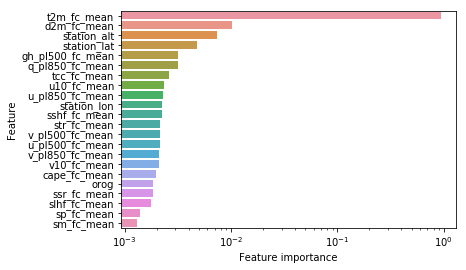

In [61]:
sns.barplot(data=fi_df, x='Feature importance', y='Feature')
plt.xscale('log')

As expected, by far the most important feature is `t2m_fc_mean`. Does the ordering of the remaining features make meteorological sense?

There some other really cool ways of interpreting a random forest. For more information check out this notebook: https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb

## Your turn

Again, here are some challenges for all of you that are bored ;)

1. The different stations have very different characteristics. Try building a model (e.g. linear regression) for each station individually. See if you can improve the validation and test score.
2. Try adding some time information (for example the month as a feature. Does this improve the forecast?
3. Try to get as good a score as possible. Be creative and use Google!